# Business Understanding

## Problems Statement

Apartemen merupakan salah satu jawaban dari kebutuhan tempat tinggal di era modern dengan keadaan lahan pemukiman yang terbatas dan aktifitas bisnis yang padat di area perkotaan. oleh karena itu, penentuan harga apartemen yang terpengaruh dengan berbagai faktor internal dan eksternal merupakan hal yang menarik. 

Penawaran unit apartemen biasa dilakukan baik oleh perusahaan maupun individu. Penjual dapat menjual unit apartemen mereka di platform dengan menentukan harga aprtemen mereka.  Salah satu tantangan terbesar bagi seorang agent property adalah untuk menyesuaikan dengan harga pasar. Apabila harga apartemen terlalu tinggi dibanding dengan harga pasar, apartemen akan sulit untuk dijual. Sebaliknya, apa bila harganya terlalu rendah, pemilik apartemen akan kesulitan untuk medapatkan keuntunga yang maksimal.

## Goals
Berdasarkan permasalahan tersebut, seorang agent property tentu perlu memiliki 'tool' yang dapat memprediksi serta membantu klien mereka (dalam hal ini pemilik apartemen) untuk dapat **menentukan harga jual apartemen yang tepat untuk tiap apartemen yang baru akan mereka jual**. Adanya perbedaan pada berbagai fitur yang terdapat pada suatu apartemen, seperti tipe apartemen, lokasi, fasilitas, luasan, dan tahun pembangunan dapat menambah keakuratan prediksi harga jual apartemen yang bersaing dengan harga pasar.

Bagi seorang agent  property, prediction tool yang dapat memberikan prediksi harga secara fair tentu dapat meningkatkan jumlah client. Dengan kata lain, semakin banyak client berarti dapat meningkatkan keuntungan bagi seorang agent property.

## Data Dictionary

| Attribute | Description |
| --- | --- |
| Hallway Type | Apartment type |
| TimeToSubway | Time needed to the nearest subway station |
| SubwayStation | The name of the nearest subway station |
| N_FacilitiesNearBy(ETC) | The number of facilities nearby |
| N_FacilitiesNearBy(PublicOffice) | The number of public office facilities nearby |
| N_SchoolNearBy(University) | The number of universities nearby |
| N_Parkinglot(Basement) | The number of the parking lot |
| YearBuilt | The year the apartment was built |
| N_FacilitiesInApt | Number of facilities in the apartment |
| Size(sqft) | The apartment size (in square feet) |
| SalePrice | The apartment price (Won) |


# Import Data and Libraries

In [280]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb

import time

import shap

import pickle

# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline # make library ini soalnya library SMOTE ngga bisa disatuin dengan Pipeline dari sklearn 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE

from scipy.stats import kstest, mannwhitneyu

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [157]:
df = pd.read_csv('data_daegu_apartment.csv')
df

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1387,346017
1,terraced,10min~15min,Kyungbuk_uni_hospital,1.0,5.0,1.0,0.0,1986,4,914,150442
2,mixed,15min~20min,Chil-sung-market,1.0,7.0,3.0,56.0,1997,5,558,61946
3,mixed,5min~10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,914,165486
4,terraced,0-5min,Sin-nam,0.0,1.0,2.0,536.0,2006,5,1743,311504
...,...,...,...,...,...,...,...,...,...,...,...
4118,terraced,0-5min,Sin-nam,0.0,3.0,2.0,475.0,2008,8,914,323008
4119,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,1451,242477
4120,mixed,15min~20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,1761,168141
4121,corridor,5min~10min,Daegu,2.0,5.0,0.0,76.0,1985,3,676,73451


## Important Function

In [158]:
def showNormalityAssesment(dataset, feature):
    _ , p_value= kstest(dataset[feature], 'norm')

    if p_value > 0.05:
        print(f"Fitur {feature} berdistribusi normal")
    else:
        print(f"Fitur {feature} tidak berdistribusi normal")

# Exploratory Data Analysis

In [159]:
df['TimeToSubway'].unique()

array(['0-5min', '10min~15min', '15min~20min', '5min~10min',
       'no_bus_stop_nearby'], dtype=object)

In [160]:
map_TTS = {'10min~15min' : '10min-15min',
           '15min~20min' : '15min-20min',
           '5min~10min' : '5min-10min',
           'no_bus_stop_nearby' : 'tidak ada bus'}

df['TimeToSubway'] = df['TimeToSubway'].replace(map_TTS)

df


,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0.0,3.0,2.0,1270.0,2007,10,1387,346017
1,terraced,10min-15min,Kyungbuk_uni_hospital,1.0,5.0,1.0,0.0,1986,4,914,150442
2,mixed,15min-20min,Chil-sung-market,1.0,7.0,3.0,56.0,1997,5,558,61946
3,mixed,5min-10min,Bangoge,5.0,5.0,4.0,798.0,2005,7,914,165486
4,terraced,0-5min,Sin-nam,0.0,1.0,2.0,536.0,2006,5,1743,311504
...,...,...,...,...,...,...,...,...,...,...,...
4118,terraced,0-5min,Sin-nam,0.0,3.0,2.0,475.0,2008,8,914,323008
4119,mixed,15min-20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,1451,242477
4120,mixed,15min-20min,Myung-duk,5.0,6.0,5.0,536.0,1993,4,1761,168141
4121,corridor,5min-10min,Daegu,2.0,5.0,0.0,76.0,1985,3,676,73451


In [161]:
flt_int = {'N_FacilitiesNearBy(PublicOffice)' : int,
'N_SchoolNearBy(University)' : int,
'N_Parkinglot(Basement)' : int,
'N_FacilitiesNearBy(ETC)' : int}

df = df.astype(flt_int)

In [162]:
numerical_feature_list = df.select_dtypes(exclude= ["object", "int32"]).columns
categorical_feature_list = df.select_dtypes(include= "object").columns

In [163]:
df_eda = df.copy()
df_eda.head()

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0,3,2,1270,2007,10,1387,346017
1,terraced,10min-15min,Kyungbuk_uni_hospital,1,5,1,0,1986,4,914,150442
2,mixed,15min-20min,Chil-sung-market,1,7,3,56,1997,5,558,61946
3,mixed,5min-10min,Bangoge,5,5,4,798,2005,7,914,165486
4,terraced,0-5min,Sin-nam,0,1,2,536,2006,5,1743,311504


In [164]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   HallwayType                       4123 non-null   object
 1   TimeToSubway                      4123 non-null   object
 2   SubwayStation                     4123 non-null   object
 3   N_FacilitiesNearBy(ETC)           4123 non-null   int64 
 4   N_FacilitiesNearBy(PublicOffice)  4123 non-null   int64 
 5   N_SchoolNearBy(University)        4123 non-null   int64 
 6   N_Parkinglot(Basement)            4123 non-null   int64 
 7   YearBuilt                         4123 non-null   int64 
 8   N_FacilitiesInApt                 4123 non-null   int64 
 9   Size(sqf)                         4123 non-null   int64 
 10  SalePrice                         4123 non-null   int64 
dtypes: int64(8), object(3)
memory usage: 354.4+ KB


In [165]:
df_eda.isnull().sum()

HallwayType                         0
TimeToSubway                        0
SubwayStation                       0
N_FacilitiesNearBy(ETC)             0
N_FacilitiesNearBy(PublicOffice)    0
N_SchoolNearBy(University)          0
N_Parkinglot(Basement)              0
YearBuilt                           0
N_FacilitiesInApt                   0
Size(sqf)                           0
SalePrice                           0
dtype: int64

In [166]:
df_eda.describe()

,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
count,4123.000000,4123.000000,4123.000000,4123.000000,4123.000000,4123.000000,4123.000000,4123.000000
mean,1.930876,4.135338,2.746301,568.979141,2002.999757,5.817851,954.630851,221767.926995
std,2.198832,1.802640,1.496610,410.372742,8.905768,2.340507,383.805648,106739.839945
min,0.000000,0.000000,0.000000,0.000000,1978.000000,1.000000,135.000000,32743.000000
25%,0.000000,3.000000,2.000000,184.000000,1993.000000,4.000000,644.000000,144752.000000
50%,1.000000,5.000000,2.000000,536.000000,2006.000000,5.000000,910.000000,209734.000000
75%,5.000000,5.000000,4.000000,798.000000,2008.000000,7.000000,1149.000000,291150.000000
max,5.000000,7.000000,5.000000,1321.000000,2015.000000,10.000000,2337.000000,585840.000000


In [167]:
display(df_eda, df_eda.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   HallwayType                       4123 non-null   object
 1   TimeToSubway                      4123 non-null   object
 2   SubwayStation                     4123 non-null   object
 3   N_FacilitiesNearBy(ETC)           4123 non-null   int64 
 4   N_FacilitiesNearBy(PublicOffice)  4123 non-null   int64 
 5   N_SchoolNearBy(University)        4123 non-null   int64 
 6   N_Parkinglot(Basement)            4123 non-null   int64 
 7   YearBuilt                         4123 non-null   int64 
 8   N_FacilitiesInApt                 4123 non-null   int64 
 9   Size(sqf)                         4123 non-null   int64 
 10  SalePrice                         4123 non-null   int64 
dtypes: int64(8), object(3)
memory usage: 354.4+ KB


,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(PublicOffice),N_SchoolNearBy(University),N_Parkinglot(Basement),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0,3,2,1270,2007,10,1387,346017
1,terraced,10min-15min,Kyungbuk_uni_hospital,1,5,1,0,1986,4,914,150442
2,mixed,15min-20min,Chil-sung-market,1,7,3,56,1997,5,558,61946
3,mixed,5min-10min,Bangoge,5,5,4,798,2005,7,914,165486
4,terraced,0-5min,Sin-nam,0,1,2,536,2006,5,1743,311504
...,...,...,...,...,...,...,...,...,...,...,...
4118,terraced,0-5min,Sin-nam,0,3,2,475,2008,8,914,323008
4119,mixed,15min-20min,Myung-duk,5,6,5,536,1993,4,1451,242477
4120,mixed,15min-20min,Myung-duk,5,6,5,536,1993,4,1761,168141
4121,corridor,5min-10min,Daegu,2,5,0,76,1985,3,676,73451


None

In [168]:
for numeric_feature in numerical_feature_list:
    showNormalityAssesment(df_eda, numeric_feature)

Fitur N_FacilitiesNearBy(ETC) tidak berdistribusi normal
Fitur N_FacilitiesNearBy(PublicOffice) tidak berdistribusi normal
Fitur N_SchoolNearBy(University) tidak berdistribusi normal
Fitur N_Parkinglot(Basement) tidak berdistribusi normal
Fitur YearBuilt tidak berdistribusi normal
Fitur N_FacilitiesInApt tidak berdistribusi normal
Fitur Size(sqf) tidak berdistribusi normal
Fitur SalePrice tidak berdistribusi normal


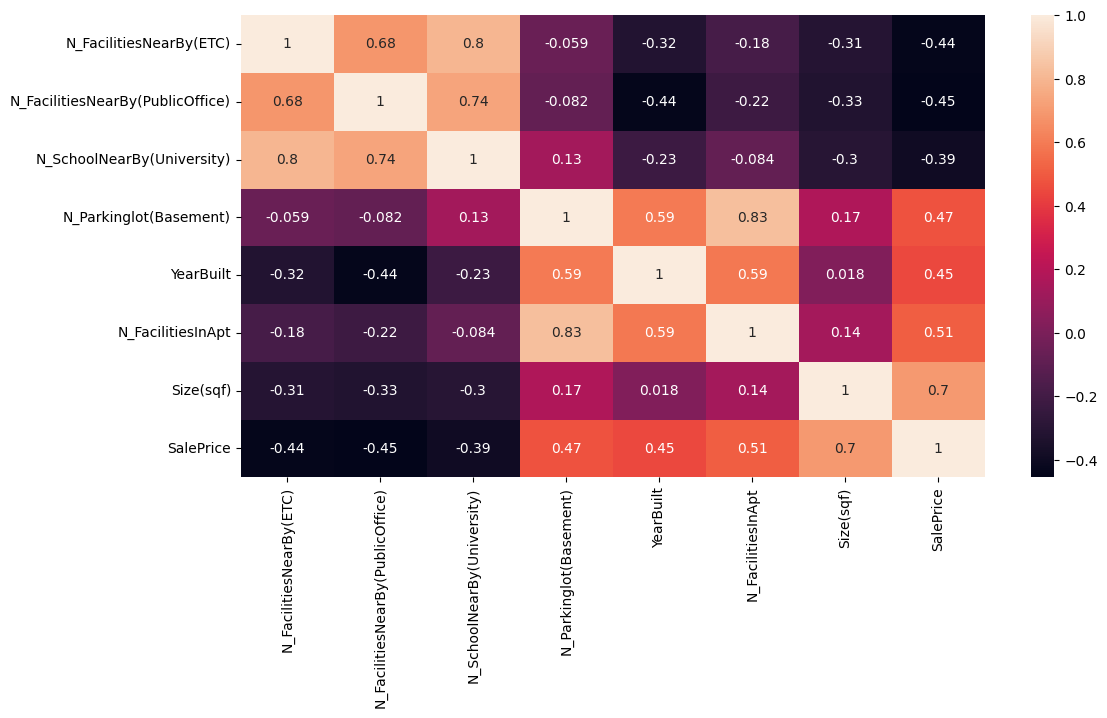

In [169]:
plt.figure(figsize= (12, 6))
sb.heatmap(
    df_eda[numerical_feature_list].corr(),
    annot= True
)

plt.show()

menghapus feature 'N_Parkinglot(Basement)', 'N_SchoolNearBy(University)', 'N_FacilitiesNearBy(PublicOffice)', karena sudah terwakilkan dengan feature 'N_FacilitiesNearBy(ETC)' dan 'N_FacilitiesInApt'

In [170]:
df_eda.drop(columns= ['N_Parkinglot(Basement)', 'N_SchoolNearBy(University)', 'N_FacilitiesNearBy(PublicOffice)'], inplace= True)

In [171]:
fsl_apt = df_eda[['N_FacilitiesNearBy(ETC)', 'N_FacilitiesInApt', 'SalePrice']]
fsl_apt

,N_FacilitiesNearBy(ETC),N_FacilitiesInApt,SalePrice
0,0,10,346017
1,1,4,150442
2,1,5,61946
3,5,7,165486
4,0,5,311504
...,...,...,...
4118,0,8,323008
4119,5,4,242477
4120,5,4,168141
4121,2,3,73451


In [172]:
display(fsl_apt.max(), fsl_apt.min())

N_FacilitiesNearBy(ETC)         5
N_FacilitiesInApt              10
SalePrice                  585840
dtype: int64

N_FacilitiesNearBy(ETC)        0
N_FacilitiesInApt              1
SalePrice                  32743
dtype: int64

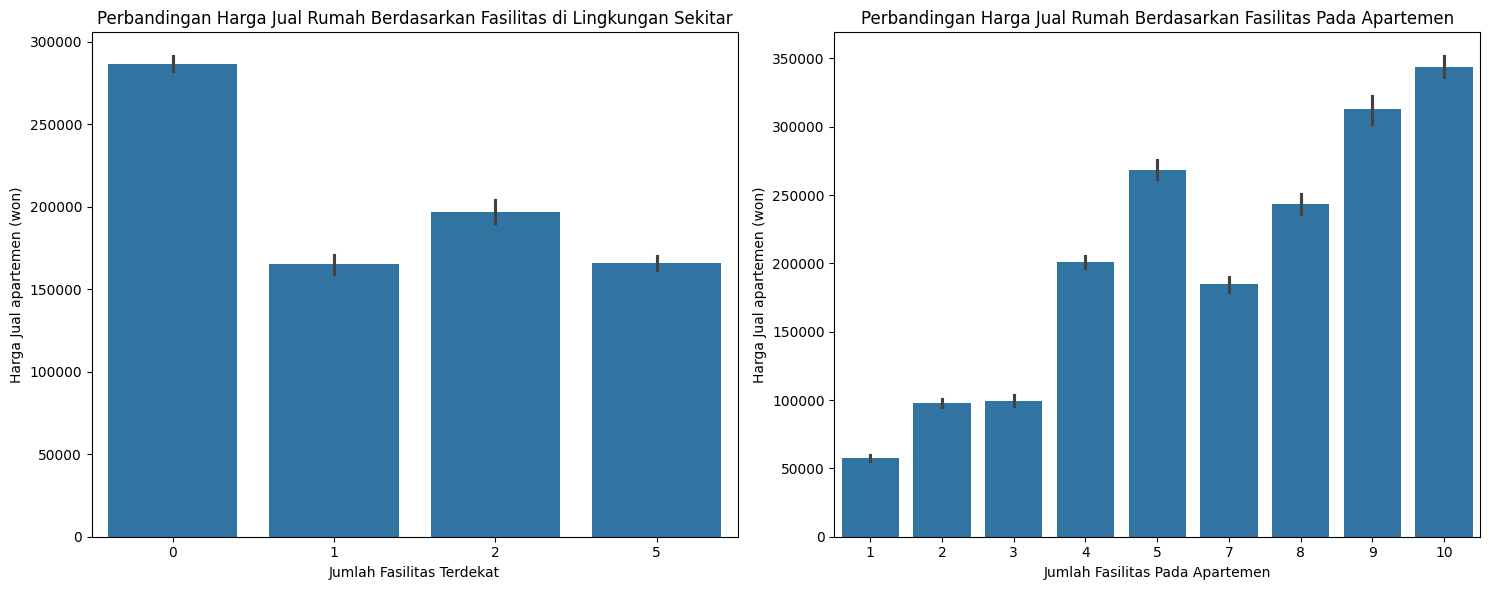

None

,N_FacilitiesNearBy(ETC),N_FacilitiesInApt,SalePrice
2128,0,10,585840
2918,0,10,570796
550,0,10,570796
204,0,10,566371
234,0,10,566371


In [173]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sb.barplot(
    data=df_eda,
    x="N_FacilitiesNearBy(ETC)",
    y='SalePrice',
    ax=axes[0]
)
axes[0].set_title("Perbandingan Harga Jual Rumah Berdasarkan Fasilitas di Lingkungan Sekitar")
axes[0].set_ylabel("Harga Jual apartemen (won)")
axes[0].set_xlabel("Jumlah Fasilitas Terdekat")

sb.barplot(
    data=df_eda,
    x="N_FacilitiesInApt",
    y='SalePrice',
    ax=axes[1]
)
axes[1].set_title("Perbandingan Harga Jual Rumah Berdasarkan Fasilitas Pada Apartemen")
axes[1].set_ylabel("Harga Jual apartemen (won)")
axes[1].set_xlabel("Jumlah Fasilitas Pada Apartemen")

plt.tight_layout()

display(plt.show(), fsl_apt.sort_values('SalePrice', ascending= False).head())

diketahui bahwa jumlah fasilitas disekitar tidak terlalu memengaruhi harga jual apartement, namun fasilitas yang terdapat pada apartement itu sendiri sangat memengaruhi, dimana seakin banyak fasilitas semakin tinggi harga apartemen.

Text(0.5, 0, 'Tipe Apaertemen')

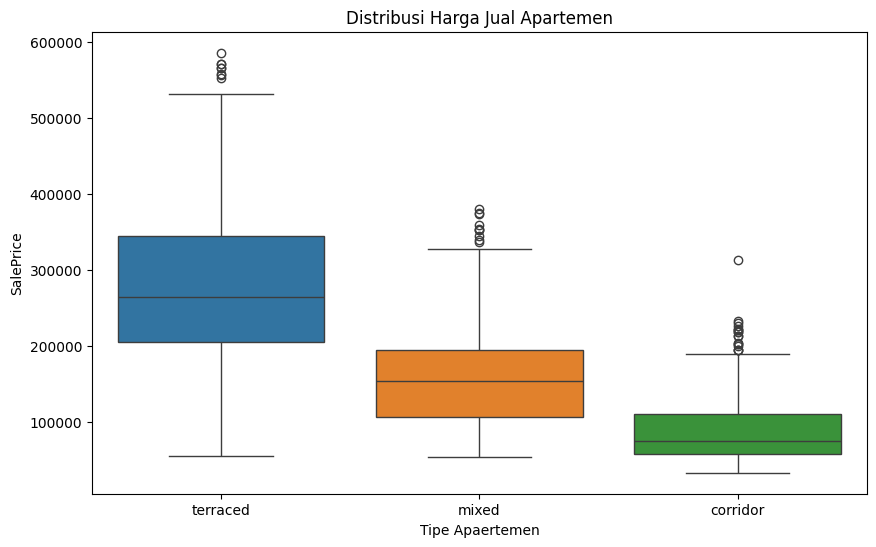

In [174]:
plt.figure(figsize= (10,6))
plt.ticklabel_format(style= 'plain')

sb.boxplot(
    data= df_eda,
    y= 'SalePrice',
    x= 'HallwayType',
    hue= 'HallwayType',
)

plt.title('Distribusi Harga Jual Apartemen')
plt.xlabel('Tipe Apaertemen')

In [175]:
Q1_trc = df_eda[df_eda['HallwayType'] == 'terraced']['SalePrice'].quantile(0.25)
Q3_trc = df_eda[df_eda['HallwayType'] == 'terraced']['SalePrice'].quantile(0.75)
IQR_trc = Q3_trc - Q1_trc
ats_trc = Q3_trc + (1.5 * IQR_trc)
bwh_trc = Q1_trc - (1.5 * IQR_trc)

Q1_mxd = df_eda[df_eda['HallwayType'] == 'mixed']['SalePrice'].quantile(0.25)
Q3_mxd = df_eda[df_eda['HallwayType'] == 'mixed']['SalePrice'].quantile(0.75)
IQR_mxd = Q3_mxd - Q1_mxd
ats_mxd = Q3_mxd + (1.5 * IQR_mxd)
bwh_mxd = Q1_mxd - (1.5 * IQR_mxd)

Q1_crd = df_eda[df_eda['HallwayType'] == 'corridor']['SalePrice'].quantile(0.25)
Q3_crd = df_eda[df_eda['HallwayType'] == 'corridor']['SalePrice'].quantile(0.75)
IQR_crd = Q3_crd - Q1_crd
ats_crd = Q3_crd + (1.5 * IQR_crd)
bwh_crd = Q1_crd - (1.5 * IQR_crd)

In [176]:
data = {
    'Q1': [Q1_trc, Q1_mxd, Q1_crd],
    'Q3': [Q3_trc, Q3_mxd, Q3_crd],
    'IQR': [IQR_trc, IQR_mxd, IQR_crd],
    'Batas Atas (Upper Bound)': [ats_trc, ats_mxd, ats_crd],
    'Batas Bawah (Lower Bound)': [bwh_trc, bwh_mxd, bwh_crd]
}

hlw_prc_apt = pd.DataFrame(data, index=['terraced', 'mixed', 'corridor'])


In [177]:
upper_bounds = {
    'terraced': 552654.00,
    'mixed': 328097.75,
    'corridor': 189601.50
}

percentage_outliers = {}

for htype, upper_bound in upper_bounds.items():
    df_subset = df_eda[df_eda['HallwayType'] == htype]
    total_count = len(df_subset)
    outlier_count = len(df_subset[df_subset['SalePrice'] > upper_bound])
    if total_count > 0:
        percentage = (outlier_count / total_count) * 100
    else:
        percentage = 0
    percentage_outliers[htype] = f"{percentage:.2f}% ({outlier_count} dari {total_count})"

hlw_prc_op = pd.Series(percentage_outliers).rename('Persentase Outlier (> Batas Atas)')
hlw_prc_op = pd.DataFrame(hlw_prc_op)

In [178]:
display(hlw_prc_apt, hlw_prc_op)

,Q1,Q3,IQR,Batas Atas (Upper Bound),Batas Bawah (Lower Bound)
terraced,205309.0,344247.0,138938.0,552654.00,-3098.00
mixed,105751.5,194690.0,88938.5,328097.75,-27656.25
corridor,57964.0,110619.0,52655.0,189601.50,-21018.50


,Persentase Outlier (> Batas Atas)
terraced,0.32% (8 dari 2528)
mixed,0.88% (10 dari 1131)
corridor,3.88% (18 dari 464)


dari hasil pengecek pada data outlier terdapat >5% data outlier pada masing-masing tipe apartemen. Kita dapat anggap data ini sebagai apartemen dengan harga OverPrice (melebihi harga pasar).

In [179]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   HallwayType              4123 non-null   object
 1   TimeToSubway             4123 non-null   object
 2   SubwayStation            4123 non-null   object
 3   N_FacilitiesNearBy(ETC)  4123 non-null   int64 
 4   YearBuilt                4123 non-null   int64 
 5   N_FacilitiesInApt        4123 non-null   int64 
 6   Size(sqf)                4123 non-null   int64 
 7   SalePrice                4123 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 257.8+ KB


In [180]:
df_eda.head()

,HallwayType,TimeToSubway,SubwayStation,N_FacilitiesNearBy(ETC),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,Kyungbuk_uni_hospital,0,2007,10,1387,346017
1,terraced,10min-15min,Kyungbuk_uni_hospital,1,1986,4,914,150442
2,mixed,15min-20min,Chil-sung-market,1,1997,5,558,61946
3,mixed,5min-10min,Bangoge,5,2005,7,914,165486
4,terraced,0-5min,Sin-nam,0,2006,5,1743,311504


In [181]:
mode_fsl_trc = df_eda[df_eda['HallwayType']== 'terraced']['N_FacilitiesInApt'].mode()[0]
mode_tts_trc = df_eda[df_eda['HallwayType']== 'terraced']['TimeToSubway'].mode()[0]
mode_yb_trc = df_eda[df_eda['HallwayType']== 'terraced']['YearBuilt'].mode()[0]
mean_sze_trc = df_eda[df_eda['HallwayType']== 'terraced']['Size(sqf)'].mean()

mode_fsl_crd = df_eda[df_eda['HallwayType']== 'corridor']['N_FacilitiesInApt'].mode()[0]
mode_tts_crd = df_eda[df_eda['HallwayType']== 'corridor']['TimeToSubway'].mode()[0]
mode_yb_crd = df_eda[df_eda['HallwayType']== 'corridor']['YearBuilt'].mode()[0]
mean_sze_crd = df_eda[df_eda['HallwayType']== 'corridor']['Size(sqf)'].mean()

mode_fsl_mxd = df_eda[df_eda['HallwayType']== 'mixed']['N_FacilitiesInApt'].mode()[0]
mode_tts_mxd = df_eda[df_eda['HallwayType']== 'mixed']['TimeToSubway'].mode()[0]
mode_yb_mxd = df_eda[df_eda['HallwayType']== 'mixed']['YearBuilt'].mode()[0]
mean_sze_mxd = df_eda[df_eda['HallwayType']== 'mixed']['Size(sqf)'].mean()

In [182]:
data_modus = {
'Mayoritas memiliki fasilitas berjumlah' : [mode_fsl_trc, mode_fsl_crd, mode_fsl_mxd],
'Mayoritas jarak dengan subway' : [mode_tts_trc, mode_tts_crd, mode_tts_mxd], 
'Mayoritas dibangun tahun' : [mode_yb_trc, mode_yb_crd, mode_yb_mxd],
'Rata-rata luas apartemen' : [mean_sze_trc, mean_sze_crd, mean_sze_mxd]
    }
hlw_fsl_yb = pd.DataFrame(data_modus, index= ['terraced', 'corridor', 'mixed'])
hlw_fsl_yb

,Mayoritas memiliki fasilitas berjumlah,Mayoritas jarak dengan subway,Mayoritas dibangun tahun,Rata-rata luas apartemen
terraced,5,0-5min,2007,1082.332674
corridor,3,10min-15min,1992,509.153017
mixed,7,15min-20min,2005,851.953139


Pengecekan pada nilai modus ini untuk mengetahui jumlah fasilitas, jarak dengan subway, tahun dibangun, dan rata-rata luasan dari kebanyakan unit yang terjual pada masing masing tipe apartemen. Data ini dapat digunakan sebagai pembanding untuk memberikan nilai jual yang lebih pada unit yang selanjutnya akan dijual apabila memiliki kelebihan dari 4 indikator ini.

# Modeling

In [185]:
df_modeling = df.copy()
df_modeling.drop(columns= ['SubwayStation','N_SchoolNearBy(University)', 'N_FacilitiesNearBy(PublicOffice)', 'N_Parkinglot(Basement)'], inplace= True)
df_modeling

,HallwayType,TimeToSubway,N_FacilitiesNearBy(ETC),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice
0,terraced,0-5min,0,2007,10,1387,346017
1,terraced,10min-15min,1,1986,4,914,150442
2,mixed,15min-20min,1,1997,5,558,61946
3,mixed,5min-10min,5,2005,7,914,165486
4,terraced,0-5min,0,2006,5,1743,311504
...,...,...,...,...,...,...,...
4118,terraced,0-5min,0,2008,8,914,323008
4119,mixed,15min-20min,5,1993,4,1451,242477
4120,mixed,15min-20min,5,1993,4,1761,168141
4121,corridor,5min-10min,2,1985,3,676,73451


memasukan kolom baru yang berisikan kategori harga sesuai dengan hasil analisa yang dilakukan sebelumnya, dimana :
- Apabila harga melebihi batas atas maka price category pada aprtemen tersebut akan masuk kedalam kategori *Overprice (OP)* : 1
- Apabila harga tidak melebihi batas atas maka price catgeory pada apartemen tersebut akan masuk kedalam kategori *Marketprice (MP)* : 0

In [191]:
upper_bounds = {
    'terraced': 552654.00,
    'mixed': 328097.75,
    'corridor': 189601.50
}

def priceCategory(row):
    htype = row['HallwayType']
    sale_price = row['SalePrice']
    
    batas_atas = upper_bounds.get(htype)
    
    if sale_price > batas_atas:
        return 1
    else:
        return 0
    
df_modeling['PriceCategory'] = df_modeling.apply(priceCategory, axis=1)
df_modeling.sort_values('SalePrice', ascending= False)

,HallwayType,TimeToSubway,N_FacilitiesNearBy(ETC),YearBuilt,N_FacilitiesInApt,Size(sqf),SalePrice,PriceCategory
2128,terraced,0-5min,0,2007,10,1928,585840,1
2918,terraced,0-5min,0,2007,10,1928,570796,1
550,terraced,0-5min,0,2007,10,1928,570796,1
204,terraced,0-5min,0,2007,10,1643,566371,1
234,terraced,0-5min,0,2007,10,1928,566371,1
...,...,...,...,...,...,...,...,...
1068,corridor,10min-15min,5,1992,3,355,35398,0
804,corridor,10min-15min,5,1992,3,355,34513,0
163,corridor,10min-15min,5,1992,3,355,34513,0
3625,corridor,10min-15min,5,1992,3,355,34070,0


## Data preProcessing

In [213]:
X = df_modeling.drop(['PriceCategory', 'SalePrice'], axis=1)
y = df_modeling.PriceCategory

In [214]:
X = pd.get_dummies(X, columns=['HallwayType'], drop_first=True)

In [215]:
time_order = ['0-5min', '10min-15min', '15min-20min', '5min-10min',
       'tidak ada bus']

time_to_subway_mapping = {time: i for i, time in enumerate(time_order)}
X['TimeToSubway_Encoded'] = X['TimeToSubway'].map(time_to_subway_mapping)

X = X.drop('TimeToSubway', axis=1)

In [216]:
feature_transformer = ColumnTransformer([
    ('feature_scaling', RobustScaler(), ['N_FacilitiesNearBy(ETC)', 'YearBuilt', 'N_FacilitiesInApt', 'Size(sqf)']),    
], remainder= "passthrough")
feature_transformer

,transformers,"[('feature_scaling', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"


## Model Development

In [217]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size= 0.7,
    random_state= 10,
    stratify= y,
    shuffle= True
)

## Random Forest

In [218]:
random_forest_base_model = RandomForestClassifier(random_state= 42)

### Tanpa Data Resampiling

In [219]:
rf_modelling_pipeline = Pipeline([
    ('feature_scaling', feature_transformer),
    ('modelling', random_forest_base_model)
])

In [220]:
rf_hyperparameter_space = {
    'modelling__max_depth' : np.arange(1, 3),
    'modelling__n_estimators' : np.arange(1, 20), 
}

In [221]:
rf_grid = GridSearchCV(
    estimator= rf_modelling_pipeline,
    param_grid= rf_hyperparameter_space,
    scoring= 'recall',
    cv= StratifiedKFold(),
)

rf_grid

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'modelling__max_depth': array([1, 2]), 'modelling__n_estimators': array([ 1, 2... 18, 19])}"
,scoring,'recall'
,n_jobs,None
,refit,True
,cv,StratifiedKFo...shuffle=False)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('feature_scaling', ...)]"


In [222]:
rf_grid.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'modelling__max_depth': array([1, 2]), 'modelling__n_estimators': array([ 1, 2... 18, 19])}"
,scoring,'recall'
,n_jobs,None
,refit,True
,cv,StratifiedKFo...shuffle=False)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('feature_scaling', ...)]"


In [223]:
best_rf_model = rf_grid.best_estimator_
rf_model_pred = best_rf_model.predict(X_test)

print(f"Performance on Validation Set : {rf_grid.best_score_ * 100}")
print(f"Performance on Test Set : {recall_score(y_test, rf_model_pred) * 100}")
print(classification_report(y_test, rf_model_pred))

Performance on Validation Set : 8.0
Performance on Test Set : 0.0
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1226
           1       0.00      0.00      0.00        11

    accuracy                           0.99      1237
   macro avg       0.50      0.50      0.50      1237
weighted avg       0.98      0.99      0.99      1237



c:\Users\Teguh Iman\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Teguh Iman\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Teguh Iman\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### Dengan Data Resampling

In [224]:
rf_modelling_resampling_pipeline = Pipeline([
    ('feature_scaling', feature_transformer),
    ('data_resampling', SMOTE()),
    ('modelling', random_forest_base_model)
])

In [225]:
rf_hyperparameter_space = {
    'modelling__max_depth' : np.arange(1, 3),
    'modelling__n_estimators' : np.arange(1, 20), 
}

In [226]:
rf_resampling_grid = GridSearchCV(
    estimator= rf_modelling_resampling_pipeline,
    param_grid= rf_hyperparameter_space,
    scoring= 'recall',
    cv= StratifiedKFold(),
)

rf_resampling_grid

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'modelling__max_depth': array([1, 2]), 'modelling__n_estimators': array([ 1, 2... 18, 19])}"
,scoring,'recall'
,n_jobs,None
,refit,True
,cv,StratifiedKFo...shuffle=False)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('feature_scaling', ...)]"


In [228]:
rf_resampling_grid.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'modelling__max_depth': array([1, 2]), 'modelling__n_estimators': array([ 1, 2... 18, 19])}"
,scoring,'recall'
,n_jobs,None
,refit,True
,cv,StratifiedKFo...shuffle=False)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('feature_scaling', ...)]"


In [229]:
best_rf_resampling_model = rf_resampling_grid.best_estimator_
rf_model_resampling_pred = best_rf_resampling_model.predict(X_test)

print(f"Performance on Validation Set : {rf_resampling_grid.best_score_ * 100}")
print(f"Performance on Test Set : {recall_score(y_test, rf_model_resampling_pred) * 100}")
print(classification_report(y_test, rf_model_resampling_pred))

Performance on Validation Set : 92.0
Performance on Test Set : 100.0
              precision    recall  f1-score   support

           0       1.00      0.22      0.37      1226
           1       0.01      1.00      0.02        11

    accuracy                           0.23      1237
   macro avg       0.51      0.61      0.19      1237
weighted avg       0.99      0.23      0.36      1237



## XGBoost

In [230]:
xgb_base_model = XGBClassifier(random_state = 42)

### Tanpa Data Resampling

In [231]:
xgb_modelling_pipeline = Pipeline([
    ('feature_scaling', feature_transformer),
    ('modelling', xgb_base_model)
])

In [232]:
xgb_hyperparameter_space = {
    'modelling__max_depth' : np.arange(1, 3),
    'modelling__n_estimators' : np.arange(1, 20), 
}

In [234]:
xgb_grid = GridSearchCV(
    estimator= xgb_modelling_pipeline,
    param_grid= xgb_hyperparameter_space,
    scoring= 'recall',
    cv= StratifiedKFold(),
)

xgb_grid

,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'modelling__max_depth': array([1, 2]), 'modelling__n_estimators': array([ 1, 2... 18, 19])}"
,scoring,'recall'
,n_jobs,None
,refit,True
,cv,StratifiedKFo...shuffle=False)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('feature_scaling', ...)]"


In [235]:
xgb_grid.fit(X_train, y_train)

,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'modelling__max_depth': array([1, 2]), 'modelling__n_estimators': array([ 1, 2... 18, 19])}"
,scoring,'recall'
,n_jobs,None
,refit,True
,cv,StratifiedKFo...shuffle=False)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('feature_scaling', ...)]"


In [236]:
best_xgb_grid_model = xgb_grid.best_estimator_
xgb_model_pred = best_xgb_grid_model.predict(X_test)

print(f"Performance on Validation Set : {xgb_grid.best_score_ * 100}")
print(f"Performance on Test Set : {recall_score(y_test, xgb_model_pred) * 100}")
print(classification_report(y_test, xgb_model_pred))

Performance on Validation Set : 0.0
Performance on Test Set : 0.0
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1226
           1       0.00      0.00      0.00        11

    accuracy                           0.99      1237
   macro avg       0.50      0.50      0.50      1237
weighted avg       0.98      0.99      0.99      1237



c:\Users\Teguh Iman\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Teguh Iman\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Teguh Iman\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### Dengan Data Resampling

In [237]:
xgb_modelling_resampling_pipeline = Pipeline([
    ('feature_scaling', feature_transformer),
    ('data_resampling', SMOTE()),
    ('modelling', xgb_base_model)
])

In [238]:
xgb_hyperparameter_space = {
    'modelling__max_depth' : np.arange(1, 3),
    'modelling__n_estimators' : np.arange(1, 20), 
}

In [239]:
xgb_resampling_grid = GridSearchCV(
    estimator= xgb_modelling_resampling_pipeline,
    param_grid= xgb_hyperparameter_space,
    scoring= 'recall',
    cv= StratifiedKFold(),
)

xgb_resampling_grid

,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'modelling__max_depth': array([1, 2]), 'modelling__n_estimators': array([ 1, 2... 18, 19])}"
,scoring,'recall'
,n_jobs,None
,refit,True
,cv,StratifiedKFo...shuffle=False)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('feature_scaling', ...)]"


In [240]:
xgb_resampling_grid.fit(X_train, y_train)

,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'modelling__max_depth': array([1, 2]), 'modelling__n_estimators': array([ 1, 2... 18, 19])}"
,scoring,'recall'
,n_jobs,None
,refit,True
,cv,StratifiedKFo...shuffle=False)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('feature_scaling', ...)]"


In [241]:
best_xgb_resampling_grid_model = xgb_resampling_grid.best_estimator_
xgb_model_resampling_pred = best_xgb_resampling_grid_model.predict(X_test)

print(f"Performance on Validation Set : {xgb_resampling_grid.best_score_ * 100}")
print(f"Performance on Test Set : {recall_score(y_test, xgb_model_resampling_pred) * 100}")
print(classification_report(y_test, xgb_model_resampling_pred))

Performance on Validation Set : 100.0
Performance on Test Set : 81.81818181818183
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1226
           1       0.06      0.82      0.11        11

    accuracy                           0.89      1237
   macro avg       0.53      0.85      0.53      1237
weighted avg       0.99      0.89      0.93      1237



## Model Development Analysis

In [262]:
rf_start_time = time.time()
best_rf_model.fit(X_train, y_train)
rf_total_time = time.time() - rf_start_time

rf_train_pred = best_rf_model.predict(X_train)
rf_pred = best_rf_model.predict(X_test)

rf_recall = recall_score(y_test, rf_pred) * 100
print(f"Model Computational Time: {rf_total_time} seconds")
print(f"Model Perfomance on Test Set: {rf_recall}")

Model Computational Time: 0.026955366134643555 seconds
Model Perfomance on Test Set: 0.0


In [263]:
rf_start_time = time.time()
best_rf_resampling_model.fit(X_train, y_train)
rf_resampling_total_time = time.time() - rf_start_time

rf_pred = best_rf_resampling_model.predict(X_test)

rf_resampling_recall = recall_score(y_test, rf_pred) * 100
print(f"Model Computational Time: {rf_resampling_total_time} seconds")
print(f"Model Perfomance on Test Set: {rf_resampling_recall}")

Model Computational Time: 0.029713869094848633 seconds
Model Perfomance on Test Set: 100.0


In [264]:
start_time = time.time()
best_xgb_grid_model.fit(X_train, y_train)
xgb_total_time = time.time() - start_time

xgb_pred = best_xgb_grid_model.predict(X_test)

xgb_recall = recall_score(y_test, xgb_pred) * 100
print(f"Model Computational Time: {xgb_total_time} seconds")
print(f"Model Perfomance on Test Set: {xgb_recall}")

Model Computational Time: 0.03137612342834473 seconds
Model Perfomance on Test Set: 0.0


In [265]:
start_time = time.time()
best_xgb_resampling_grid_model.fit(X_train, y_train)
xgb_resampling_total_time = time.time() - start_time

xgb_pred = best_xgb_resampling_grid_model.predict(X_test)

xgb_resampling_recall = recall_score(y_test, xgb_pred) * 100
print(f"Model Computational Time: {xgb_resampling_total_time} seconds")
print(f"Model Perfomance on Test Set: {xgb_resampling_recall}")

Model Computational Time: 0.034317731857299805 seconds
Model Perfomance on Test Set: 90.9090909090909


In [267]:
model_comparison_df = pd.DataFrame({
    'Algorithm': ['Random Forest', 'Random Forest', 'XGBoost', 'XGBoost'],
    'Data Resampling' : ['without Data Resampling', 'with Data Resampling (SMOTE)','without Data Resampling', 'with Data Resampling (SMOTE)'],
    'Recall Score': [rf_recall, rf_resampling_recall, xgb_recall, xgb_resampling_recall],
    'Computational Time (in seconds)' : [rf_total_time, rf_resampling_total_time, xgb_total_time, xgb_resampling_total_time]
})

model_comparison_df.sort_values('Recall Score', ascending= False)

,Algorithm,Data Resampling,Recall Score,Computational Time (in seconds)
1,Random Forest,with Data Resampling (SMOTE),100.000000,0.029714
3,XGBoost,with Data Resampling (SMOTE),90.909091,0.034318
0,Random Forest,without Data Resampling,0.000000,0.026955
2,XGBoost,without Data Resampling,0.000000,0.031376


In [268]:
best_rf_resampling_model

,steps,"[('feature_scaling', ...), ('data_resampling', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('feature_scaling', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [269]:
best_model = RandomForestClassifier(n_estimators= 3, max_depth=1)
best_model.fit(X_train, y_train)

,n_estimators,3
,criterion,'gini'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [270]:
feature_importance_df = pd.DataFrame({
    'Feature' : X_train.columns,
    'Feature Importance': best_model.feature_importances_
})

feature_importance_df.sort_values('Feature Importance', ascending= False, inplace= True)

In [274]:
print(X_train.dtypes)

N_FacilitiesNearBy(ETC)    int64
YearBuilt                  int64
N_FacilitiesInApt          int64
Size(sqf)                  int64
HallwayType_mixed           bool
HallwayType_terraced        bool
TimeToSubway_Encoded       int64
dtype: object


In [276]:
X_train['HallwayType_mixed'] = X_train['HallwayType_mixed'].astype(int)
X_train['HallwayType_terraced'] = X_train['HallwayType_terraced'].astype(int)

In [277]:
shap_value = shap.TreeExplainer(
    model=best_model,
    data=X_train,
    model_output="probability"
).shap_values(X_train)

# Model Deployment

In [288]:
best_model = RandomForestClassifier(n_estimators=3, max_depth= 1, random_state= 42)
best_model.fit(X, y)

,n_estimators,3
,criterion,'gini'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [282]:
model_path = 'D:\Purwadhika\Learning Purwadhika\Capstone 3_ML'
model_path
model_file_name = "Capstone3_model.sav"
f"{model_path}/{model_file_name}"

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Teguh Iman\AppData\Local\Temp\ipykernel_4132\1683607303.py:1: SyntaxWarning: invalid escape sequence '\P'
  model_path = 'D:\Purwadhika\Learning Purwadhika\Capstone 3_ML'


'D:\\Purwadhika\\Learning Purwadhika\\Capstone 3_ML/Capstone3_model.sav'

In [283]:
pickle.dump(
    best_model, 
    open(file= f"{model_path}/{model_file_name}", mode= "wb")
)

In [289]:
feature_transformer.fit_transform(X)

array([[-0.2, 0.06666666666666667, 1.6666666666666667, ..., False, True,
        0],
       [0.0, -1.3333333333333333, -0.3333333333333333, ..., False, True,
        1],
       [0.0, -0.6, 0.0, ..., True, False, 2],
       ...,
       [0.8, -0.8666666666666667, -0.3333333333333333, ..., True, False,
        2],
       [0.2, -1.4, -0.6666666666666666, ..., False, False, 3],
       [-0.2, 0.06666666666666667, 1.6666666666666667, ..., False, True,
        0]], shape=(4123, 7), dtype=object)

In [290]:
preprocess_file_name = f"{model_path}/Capstone3_feature_preprocess.sav" 
preprocess_file_name

'D:\\Purwadhika\\Learning Purwadhika\\Capstone 3_ML/Capstone3_feature_preprocess.sav'

In [291]:
pickle.dump(
    preprocess_file_name, 
    open(file= preprocess_file_name, mode= "wb")
)

In [292]:
model_load = pickle.load(
    open(file = f"{model_path}/{model_file_name}", mode= "rb")
)

model_load

,n_estimators,3
,criterion,'gini'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False
